# Convolutional Neural Networks

## Table of Contents

This assignment is structured as a five-part from the fundamentals of building a CNN from scratch to applying state-of-the-art transfer learning techniques on the STL-10 dataset.[1] Each part builds upon the last.

1.  **Part I — `ToyCNN`: Building Our Baseline:** We begin by implementing a small, two-layer CNN. The goal is to establish a performance **baseline** and, more importantly, to analyze its training curves to diagnose its primary weakness.

2.  **Part IIa — The Deep Dive: Implementing Batch Normalization:** Before we can fix our model, we must understand our tools. You will look "under the hood" by implementing your own `BatchNorm` layer from first principles. This will build a deep intuition for how batch normalization achieves **faster, more stable training** by correcting for internal covariate shift.[1]

3.  **Part IIb — The Deep Dive: Implementing Dropout:** Continuing our deep dive, you will implement `Dropout` from scratch. By coding the inverted dropout technique yourself, you will fundamentally understand how this form of regularization helps a model achieve **better generalization** by preventing neural co-adaptation.

4.  **Part III — `ToyCNNModified`: Iterative Improvement:** Starting with your baseline `ToyCNN`, you will systematically apply the tools (`BatchNorm`, `Dropout`), increase the model's **capacity** by making it deeper, and improve its **robustness**. You will run a mini-ablation to see the impact of each change.

5.  **Part IV — Transfer Learning with ResNet-18:** Finally, you will learn a powerful and common technique in applied computer vision. Instead of training from scratch, you will adapt a pre-trained ResNet-18 model, leveraging its powerful learned features to achieve **state-of-the-art performance** on our dataset with minimal training.

Here is a quick comparison of the journey:

| Stage | What you will implement | Main Benefit | Typical Outcome (Val Acc) |
| :--- | :--- | :--- | :--- |
| I. `ToyCNN` (Baseline) | A basic CNN + training loop | Establish baseline & diagnose overfitting | >50% |
| IIa. `BatchNorm` (from scratch) | `BatchNorm` | Understand training stabilization & speed | (Applied in Part III) |
| IIb. `Dropout` (from scratch) | `Dropout` | Understand regularization | (Applied in Part III) |
| III. `ToyCNNModified` (Improved) | Deeper net + BN + Dropout | Systematic improvement & generalization | > 60% |
| IV. ResNet-18 Fine-Tuning | Head swap + fine-tuning schedule | Leverage pre-trained models for SOTA results | > 90% |

## Part 0: Setup

### Preparation

Run this to mount your Google Drive if you are using Google Colab, otherwise skip.

Click on Runtime $\rightarrow$ Change Runtime Type, and select "GPU" under hardware accelerator.

In [1]:
import sys
print(sys.version)

3.13.9 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 19:11:29) [Clang 20.1.8 ]


In [ ]:
import os
from google.colab import drive

if not os.path.exists('/content/drive/'):
    drive.mount('/content/drive/')

project_dir = input("Please enter the path to your project directory within Google Drive (e.g., your_project_folder/): ")

full_project_dir = os.path.join('/content/drive/MyDrive', project_dir)

# Change the current working directory
try:
    %cd $full_project_dir
    print(f"Changed current working directory to: {os.getcwd()}")
except Exception as e:
    print(f"Error changing directory: {e}")
    print("Please ensure the path is correct and try again.")

### Environment Setup

1. For mac - use `conda/install.sh` to create a new environment and install the required packages. Run the installation cell below (you can comment it out after successful installation). and activate the environment by running `conda activate cda_hw3` on the terminal.
2. For google colab - use the `pip install -e .` command in the cell below 
   

In [2]:
# Feel free to comment this cell after the conda installation is successful
use_colab = False

# for mac users
#!conda/install.sh

# for colab
# %pip install -e .
# use_colab = True


In [3]:
import importlib, sys
sys.modules['imp'] = importlib

In [4]:
!pip install torch

In [5]:
import os

import torch

from cs6740.runner import Trainer
from cs6740.dl_utils import get_optimizer
from cs6740.toy_cnn import ToyCNN
from cs6740.toy_cnn_modified import ToyCNNModified
from cs6740.my_resnet import MyResNet18
from cs6740.data_transforms import get_normalized_transforms

from cs6740.dl_utils import save_trained_model_weights

%load_ext autoreload
%autoreload 2

In [6]:
from tests.utils import verify

from tests.test_toy_cnn import test_toy_cnn
from tests.test_toy_cnn_modified import test_toy_cnn_modified
from tests.test_my_resnet import test_my_resnet

from tests.test_batchnorm import (
    test_batchnorm_forward_train,
    test_batchnorm_forward_test, 
    test_batchnorm_backward
)

from tests.test_dropout import test_dropout_forward, test_dropout_backward


In [7]:
is_cuda = True
is_cuda = (
    is_cuda and torch.cuda.is_available()
)
print("Cuda available: ", is_cuda)

is_apple_silicon = True
is_apple_silicon = is_apple_silicon and torch.backends.mps.is_available()
print(f"Apple silicon available: {is_apple_silicon}")

Cuda available:  False
Apple silicon available: True


In [8]:
data_path = "./data/" if not use_colab else "./data/"
model_path = "../model_checkpoints/" if not use_colab else "./model_checkpoints/"

## Part 1: ToyCNN
Training a PyTorch network revolves around four essentials:
1. **Dataset**
2. **Model** – a module encoding the architecture we wish to optimize.
3. **Loss function** – a criterion that measures the gap between predictions and ground truth.
4. **Optimizer** – an algorithm that updates the model parameters to reduce the loss.

### Part 1.1: Datasets
We begin by constructing the dataset objects. Throughout this project we rely on the [STL-10 dataset](https://cs.stanford.edu/~acoates/stl10/), which contains 96×96 RGB images spanning 10 classes.

### Dataset Summary Statistics

Let's explore the dataset to understand its characteristics better.

In [9]:
from cs6740.image_loader import ImageLoader
import numpy as np

train_dataset = ImageLoader(data_path, split='train', transform=None)
test_dataset = ImageLoader(data_path, split='test', transform=None)

# Dataset sizes
print("=" * 60)
print("STL-10 Dataset Summary")
print("=" * 60)
print(f"Training set size: {len(train_dataset):,} images")
print(f"Test set size: {len(test_dataset):,} images")
print(f"Total dataset size: {len(train_dataset) + len(test_dataset):,} images")
print()

# Get class names from the dataset
class_names = list(train_dataset.class_dict.keys())
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {', '.join(class_names)}")
print()

# Image dimensions
sample_img, sample_label = train_dataset[0]
if hasattr(sample_img, 'shape'):
    img_shape = sample_img.shape
else:
    img_shape = np.array(sample_img).shape
print(f"Image dimensions: {img_shape} (Height x Width x Channels)")
print(f"Image type: RGB color images")
print("=" * 60)

STL-10 Dataset Summary
Training set size: 5,000 images
Test set size: 5,000 images
Total dataset size: 10,000 images

Number of classes: 10
Class names: airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck

Image dimensions: (96, 96, 3) (Height x Width x Channels)
Image type: RGB color images


### Sample Images from Each Class

Let's visualize sample images from each class to understand what the network will learn.

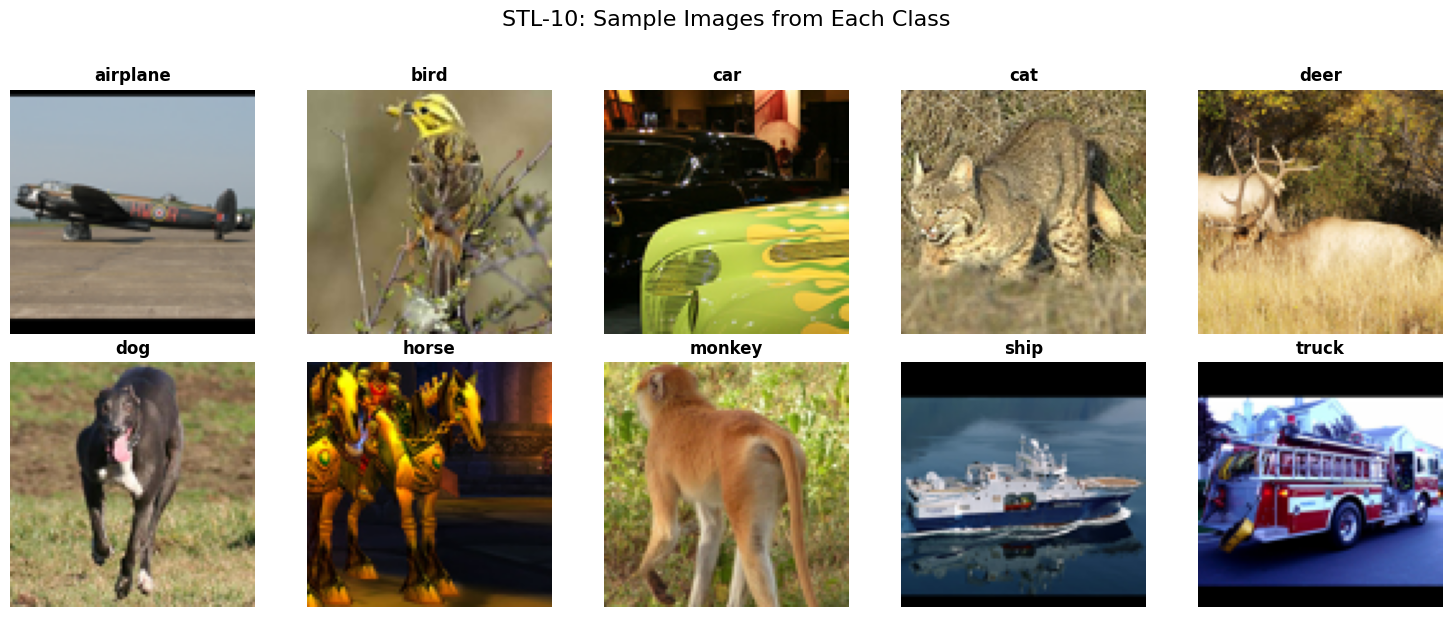

In [10]:
import matplotlib.pyplot as plt
import numpy as np

class_samples = {i: None for i in range(10)}
for i in range(len(train_dataset)):
    img, label = train_dataset[i]
    if class_samples[label] is None:
        class_samples[label] = img
    if all(v is not None for v in class_samples.values()):
        break

# Plot samples
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('STL-10: Sample Images from Each Class', fontsize=16, y=1.02)

for idx, (class_idx, img) in enumerate(class_samples.items()):
    row = idx // 5
    col = idx % 5
    ax = axes[row, col]
    
    if hasattr(img, 'numpy'):
        img_array = img.numpy()
    else:
        img_array = np.array(img)
    
    ax.imshow(img_array)
    ax.set_title(f'{class_names[class_idx]}', fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [11]:
# Sample a subset of images to analyze pixel distributions
num_samples = 500
pixel_values = {'Red': [], 'Green': [], 'Blue': []}

print("Analyzing pixel value distribution from 1,000 random training images...")
np.random.seed(42)
sample_indices = np.random.choice(len(train_dataset), num_samples, replace=False)

for idx in sample_indices:
    img, _ = train_dataset[idx]
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    
    pixel_values['Red'].extend(img_array[:, :, 0].flatten())
    pixel_values['Green'].extend(img_array[:, :, 1].flatten())
    pixel_values['Blue'].extend(img_array[:, :, 2].flatten())

# Calculate statistics
print("\nPixel Value Statistics (normalized to [0, 1]):")
print("-" * 50)
for channel in ['Red', 'Green', 'Blue']:
    values = np.array(pixel_values[channel])
    print(f"{channel} Channel:")
    print(f"  Mean: {values.mean():.4f}")
    print(f"  Std:  {values.std():.4f}")
    print()

print("Key Observations:")
print("• Pixel values are in range [0, 1] after normalization")
print("• Mean values are NOT zero-centered (around 0.4-0.5)")
print("• This suggests data normalization will be beneficial")
print("• We'll compute dataset mean/std for proper normalization later")

Analyzing pixel value distribution from 1,000 random training images...

Pixel Value Statistics (normalized to [0, 1]):
--------------------------------------------------
Red Channel:
  Mean: 0.4420
  Std:  0.2615

Green Channel:
  Mean: 0.4358
  Std:  0.2573

Blue Channel:
  Mean: 0.4009
  Std:  0.2725

Key Observations:
• Pixel values are in range [0, 1] after normalization
• Mean values are NOT zero-centered (around 0.4-0.5)
• This suggests data normalization will be beneficial
• We'll compute dataset mean/std for proper normalization later


### Part 1.2: Model
With the dataset ready, it's time to build the network. If PyTorch is new to you, Justin Johnson's concise [PyTorch tutorial](https://github.com/jcjohnson/pytorch-examples) is an excellent primer.

Before we can improve a model, we need to know how well a simple, "vanilla" approach performs. This first model, ToyCNN, will be our **baseline**. Its performance—both its strengths and its weaknesses—will guide all of our decisions in the later parts of this assignment.

Your next task is to implement a **two-convolution-layer** model in [toy_cnn.py]. 
1. "Two layers" refers specifically to two `nn.Conv2d` blocks.
2. Each convolution should include padding `=1`, and the usual companions—ReLU activations, pooling, and fully connected layers—must keep the tensor shapes consistent.
3. The classifier head must end with a fully connected layer producing logits for all **10 STL-10 classes**.

The following figure shows a reference architecture that can be used to satisfy the Part 1 requirements. If the image isn't loading please refer `assets/toyCNN.png`.
<div style="width:1000px; overflow:hidden;">
  <img src="assets/toyCNN.png"
       alt="Network overview"
       style="display:block; margin:0; width:1000px; object-fit:cover;" />
</div>


**TODO 1** in [toy_cnn.py]
- define `self.conv_layers`
- define `self.fc_layers`


In [12]:
print("Testing your ToyCNN architecture: ", verify(test_toy_cnn))

Testing your ToyCNN architecture:  "Correct"


In [13]:
toy_cnn_model = ToyCNN()
print(toy_cnn_model)

ToyCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=8192, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
  (loss_criterion): CrossEntropyLoss()
)


### Optimizer
**TODO 2:** Seed the configuration cell with sensible defaults for the learning rate and weight decay. Play around with these values to fine-tune performance.

In [14]:
# TODO Choose a sensible initial configuration and refine after experimentation.
# Refer to the Adam optimizer defaults in the PyTorch docs:
# https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-4}
optimizer = get_optimizer(toy_cnn_model, optimizer_config)

### Part 1.3: Trainer

Then plug the model, optimizer, and your chosen transforms—both training and validation—into the `Trainer`. When everything is wired up correctly, the loss curve should trend downward over subsequent epochs.

**Note:** For this assignment the STL-10 test split doubles as our validation set. In practice you would hold back a dedicated validation set and leave the test data untouched until final evaluation.

**Note:** These experiments run comfortably on CPU. Took 1 minute to train an Apple Silicon M3 Pro and 3 minutes on T4 GPU on Google Colab, each 20-epoch training session took roughly 1 minute. **20 epochs** is good enough to get you around the threshold for Part 1.

In [15]:
# re-init the model so that the weights are all random
inp_size = (64, 64)
toy_cnn_model_base = ToyCNN()
optimizer = get_optimizer(toy_cnn_model_base, optimizer_config)

trainer = Trainer(
    data_dir=data_path,
    model=toy_cnn_model_base,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "toy_cnn"),
    train_data_transforms=get_normalized_transforms(inp_size, data_dir=data_path),
    val_data_transforms=get_normalized_transforms(inp_size, data_dir=data_path),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
    mps=is_apple_silicon,
)

In [16]:
%%time
trainer.run_training_loop(num_epochs=20)

Epoch:1 Train Loss:0.0536 Val Loss: 0.0486 Train Accuracy: 0.3632 Validation Accuracy: 0.4142
Epoch:2 Train Loss:0.0417 Val Loss: 0.0453 Train Accuracy: 0.5082 Validation Accuracy: 0.4874
Epoch:3 Train Loss:0.0373 Val Loss: 0.0420 Train Accuracy: 0.5664 Validation Accuracy: 0.5110
Epoch:4 Train Loss:0.0322 Val Loss: 0.0431 Train Accuracy: 0.6232 Validation Accuracy: 0.4886
Epoch:5 Train Loss:0.0290 Val Loss: 0.0443 Train Accuracy: 0.6702 Validation Accuracy: 0.5102
Epoch:6 Train Loss:0.0252 Val Loss: 0.0408 Train Accuracy: 0.7134 Validation Accuracy: 0.5498
Epoch:7 Train Loss:0.0227 Val Loss: 0.0484 Train Accuracy: 0.7496 Validation Accuracy: 0.5100
Epoch:8 Train Loss:0.0185 Val Loss: 0.0615 Train Accuracy: 0.8024 Validation Accuracy: 0.4490
Epoch:9 Train Loss:0.0181 Val Loss: 0.0495 Train Accuracy: 0.8084 Validation Accuracy: 0.5232
Epoch:10 Train Loss:0.0158 Val Loss: 0.0437 Train Accuracy: 0.8320 Validation Accuracy: 0.5754
Epoch:11 Train Loss:0.0099 Val Loss: 0.0496 Train Accuracy:

In [17]:
trainer.plot_training_history()

alt.VConcatChart(...)

In [20]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.8992; Validation Accuracy = 0.5234


**TODO 3:** Obtain **50%** validation accuracy to receive full credit for Part 1.

Once you are happy with the model’s performance, store its weights so you can include them with your Gradescope submission.

In [21]:
save_trained_model_weights(toy_cnn_model_base, out_dir="./cs6740")

### [Written] Conceptual Questions

- **Q1** What is the final *generalization gap* (final training accuracy minus final validation accuracy), and what does that gap imply about performance on unseen data?
- **Q2** What would happen to the model’s learning ability if all `ReLU` activations were removed? Explain why this non-linearity is essential for the network.

### [Written] Answers
**TODO 4**

- **Q1 Response**: The final generalization gap which is the final training accuracy minus the final validation accuracy shows ( 0.8992 - 0.5234 = 0.3758). This implies that the model is overfitted and it will behave bad or churn out wrong predictions for the unseen data. It means that the model is not generalizable as it only learns the data
- **Q2 Response**:if the RELU non-linear activation is removed it will be difficult for the model to leran complex nonlinear boundaries and it might fail to capture important complex patterns and representation that require nonlinear combinations

## Part 2: Taming the Training Process

### Part 2.1: Batch Normalization
One way to make deep networks easier to train is to use more sophisticated optimization procedures such as SGD+momentum, RMSProp, or Adam. Another strategy is to change the architecture of the network to make it easier to train. One idea along these lines is batch normalization, proposed by [1] in 2015.

To understand the goal of batch normalization, it is important to first recognize that machine learning methods tend to perform better with input data consisting of uncorrelated features with zero mean and unit variance. When training a neural network, we can preprocess the data before feeding it to the network to explicitly decorrelate its features. This will ensure that the first layer of the network sees data that follows a nice distribution. However, even if we preprocess the input data, the activations at deeper layers of the network will likely no longer be decorrelated and will no longer have zero mean or unit variance, since they are output from earlier layers in the network. Even worse, during the training process the distribution of features at each layer of the network will shift as the weights of each layer are updated.

The authors of [1] hypothesize that the shifting distribution of features inside deep neural networks may make training deep networks more difficult. To overcome this problem, they propose to insert into the network layers that normalize batches. At training time, such a layer uses a minibatch of data to estimate the mean and standard deviation of each feature. These estimated means and standard deviations are then used to center and normalize the features of the minibatch. A running average of these means and standard deviations is kept during training, and at test time these running averages are used to center and normalize features.

It is possible that this normalization strategy could reduce the representational power of the network, since it may sometimes be optimal for certain layers to have features that are not zero-mean or unit variance. To this end, the batch normalization layer includes learnable shift and scale parameters for each feature dimension.

[1] [Sergey Ioffe and Christian Szegedy, "Batch Normalization: Accelerating Deep Network Training by Reducing
Internal Covariate Shift", ICML 2015.](https://arxiv.org/abs/1502.03167)

**TODO 5:** Implement the forward pass for `batchnorm_forward` and `batchnorm_backward` in `batchnorm.py`

- **Expected behavior**: 
  - With gamma=1, beta=0: means should be close to zero, stds close to one
  - With custom gamma/beta: means should equal beta, stds should equal gamma

In [22]:
test_batchnorm_forward_train()



=== Testing Batch Normalization Forward Pass (Training) ===

Before batch normalization:
  means: [ -2.3814598  -13.18038246   1.91780462]
  stds:  [27.18502186 34.21455511 37.68611762]

After batch normalization (gamma=1, beta=0)
  means: [8.88178420e-18 2.27595720e-17 5.30825384e-17]
  stds:  [0.99999999 1.         1.        ]

After batch normalization (gamma= [1. 2. 3.] , beta= [11. 12. 13.] )
  means: [11. 12. 13.]
  stds:  [0.99999999 1.99999999 2.99999999]

✓ All training-time forward pass checks passed!



- **Expected behavior** : Output should be reasonably normalized using running statistics

In [23]:
test_batchnorm_forward_test()


=== Testing Batch Normalization Forward Pass (Test Time) ===

After batch normalization (test-time):
  means: [-0.03927354 -0.04349152 -0.10452688]
  stds:  [1.01531428 1.01238373 0.97819988]

✓ Test-time forward pass checks passed!



- **Expected behavior**: Relative errors should be very small (< 1e-7)

In [24]:
test_batchnorm_backward()


=== Testing Batch Normalization Backward Pass ===

dx error:  1.0906009896756586e-09
dgamma error:  5.418458160170129e-12
dbeta error:  2.276445013433725e-12

✓ All backward pass gradient checks passed!



### Part 2.2 Dropout
In part 1, model was beginning to "memorize" the specific details and noise of the training data, rather than learning the underlying, generalizable patterns of what makes a "cat" a "cat." This happens when a network becomes too reliant on a few specific neurons or pathways, creating complex co-dependencies that don't hold up on new, unseen data.

To combat this, we can introduce a simple but remarkably effective regularization technique: Dropout [1].

During each training step, Dropout randomly "turns off" a fraction of neurons in a layer by setting their activations to zero. Think of it as forcing the network to learn with a randomly chosen, smaller version of itself at every step. This prevents any single neuron from becoming overly critical and forces the network to learn redundant, more robust features. It's like training a sports team where players have to be ready to succeed even if some of their teammates are unexpectedly benched.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

**TODO 6:** Implement the forward pass for `dropout_forward` and `dropout_backward` in `dropout.py`

- **Expected behavior**:
  - Training mode: ~(1-p) fraction of neurons should be zero
  - Test mode: no neurons should be zero, output equals input
  - Mean should be approximately preserved due to inverted dropout

In [25]:
test_dropout_forward()


=== Testing Dropout Forward Pass ===

Running tests with p =  0.25
Mean of input:  10.0002078784775
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.0002078784775
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.0002078784775
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.0002078784775
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.0002078784775
Mean of train-time output:  9.987811912159428
Mean of test-time output:  10.0002078784775
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0

✓ All forward pass checks passed!



- **Expected behavior**: Relative error should be very small (< 1e-9)

In [26]:
test_dropout_backward()


=== Testing Dropout Backward Pass ===

dx relative error:  5.44560814873387e-11

✓ Backward pass gradient check passed!



## Part 3: ToyCNN with additional modifications

In Part 2, you took a deep dive into two powerful techniques by implementing them from scratch: `Dropout` to combat overfitting and `BatchNorm `to stabilize training.   

Now, in Part 3, we will apply this knowledge. We will iteratively upgrade our `ToyCNN` into a `ToyCNNModified`, adding one feature at a time to observe its specific impact. This process of methodical improvement is central to machine learning engineering.

This part might take longer to train than Part 2. The default `num_epochs` is good enough as a starting point for you to pass this part.

**TODO 7:** Your task is to start by copying your ToyCNN architecture into the ToyCNNModified class. You will then modify it in the following steps.

### Part 3.1: Tackling Overfitting with Dropout

**The Problem:** Our first and most pressing issue is the overfitting we diagnosed in Part 1.

**The Solution:** Let's apply the Dropout layer you implemented in Part 2. As you know from your implementation, Dropout is a regularization technique that randomly sets a fraction of neuron activations to zero during each training step. This prevents the network from becoming too reliant on any single neuron or pathway, forcing it to learn more robust and redundant features.   

**TODO 8:** Modify your ToyCNNModified architecture by adding an nn.Dropout layer to the classifier head (fc_layers). A standard practice is to place it after the first fully connected layer and its activation function. Choose a reasonable dropout probability (e.g., p=0.5).

**Note:** While you implemented Dropout from scratch in Part 2 to understand the underlying mechanism, for this part you can simply use PyTorch's built-in `nn.Dropout` layer, which provides the same functionality with optimized performance.
After modifying the architecture, train the network, plot and note down its performance.

In [39]:
toy_cnn_modified_model = ToyCNNModified()
print(toy_cnn_modified_model)

ToyCNNModified(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=8192, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (loss_criterion): CrossEntropyLoss()
)


In [40]:
# TODO Choose a sensible initial configuration and refine after experimentation.
# Refer to the Adam optimizer defaults in the PyTorch docs:
# https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer_config = {"optimizer_type": "adam", "lr": 1e-3, "weight_decay": 1e-4}

In [41]:
toy_cnn_modified_model = ToyCNNModified()
inp_size = (64, 64)
optimizer = get_optimizer(toy_cnn_modified_model, optimizer_config)

trainer = Trainer(
    data_dir=data_path,
    model=toy_cnn_modified_model,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "toy_cnn_modified_model"),
    train_data_transforms=get_normalized_transforms(
        inp_size,
        data_dir=data_path,
        apply_augmentation=True,
    ),
    val_data_transforms=get_normalized_transforms(inp_size, data_dir=data_path),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
    mps=is_apple_silicon,
)

In [42]:
%%time
trainer.run_training_loop(num_epochs=20)

Epoch:1 Train Loss:0.0598 Val Loss: 0.0498 Train Accuracy: 0.2874 Validation Accuracy: 0.3910
Epoch:2 Train Loss:0.0510 Val Loss: 0.0476 Train Accuracy: 0.3838 Validation Accuracy: 0.4076
Epoch:3 Train Loss:0.0496 Val Loss: 0.0443 Train Accuracy: 0.4022 Validation Accuracy: 0.4802
Epoch:4 Train Loss:0.0469 Val Loss: 0.0424 Train Accuracy: 0.4364 Validation Accuracy: 0.5016
Epoch:5 Train Loss:0.0453 Val Loss: 0.0428 Train Accuracy: 0.4514 Validation Accuracy: 0.4984
Epoch:6 Train Loss:0.0459 Val Loss: 0.0416 Train Accuracy: 0.4636 Validation Accuracy: 0.5158
Epoch:7 Train Loss:0.0429 Val Loss: 0.0421 Train Accuracy: 0.4908 Validation Accuracy: 0.4820
Epoch:8 Train Loss:0.0423 Val Loss: 0.0398 Train Accuracy: 0.4970 Validation Accuracy: 0.5484
Epoch:9 Train Loss:0.0418 Val Loss: 0.0395 Train Accuracy: 0.5038 Validation Accuracy: 0.5364
Epoch:10 Train Loss:0.0404 Val Loss: 0.0401 Train Accuracy: 0.5224 Validation Accuracy: 0.5144
Epoch:11 Train Loss:0.0395 Val Loss: 0.0394 Train Accuracy:

In [43]:
trainer.plot_training_history()

alt.VConcatChart(...)

In [45]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.6112; Validation Accuracy = 0.5984


### [Written] Observation
- **Q3** After incorporating dropout, what do you observe about the train/validation curves and overfitting behavior?

### [Written] Answers
**TODO 9**

- **Q3 Response**: After incorporating dropout, the training accuracy decreases by a significant amount while the validation accuracy became more increases. The gap between training and validation performance narrowed, indicating reduced overfitting. Dropout helped the model generalize better, even though it slowed training convergence somewhat.

### Part 3.2: Increasing Model Capacity by Going Deeper

**The Problem:** Now that we have a tool to control overfitting, our model's performance might be limited by its simplicity. A shallow two-layer network may not have enough capacity to learn the complex hierarchy of features in the STL-10 dataset.

**The Solution:** We will increase the model's capacity by adding another convolutional block. Deeper networks can learn a sequence of features: early layers might learn edges and colors, middle layers learn textures and patterns, and later layers learn to recognize whole objects.

**TODO 10:** Take your network (which already includes Dropout) and add one more convolutional block (Conv2d -> ReLU -> MaxPool2d) to your conv_layers.

*Hint: Adding a layer will change the output shape of the convolutional base. You will need to carefully recalculate the in_features for your fc_layers to match this new flattened shape.*

In [46]:
toy_cnn_modified_model = ToyCNNModified()
print(toy_cnn_modified_model)

ToyCNNModified(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
  (loss_criterion): CrossEntropyLoss()
)


In [47]:
toy_cnn_modified_model = ToyCNNModified()
inp_size = (64, 64)
optimizer = get_optimizer(toy_cnn_modified_model, optimizer_config)

trainer = Trainer(
    data_dir=data_path,
    model=toy_cnn_modified_model,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "toy_cnn_modified_model"),
    train_data_transforms=get_normalized_transforms(
        inp_size,
        data_dir=data_path,
        apply_augmentation=True,
    ),
    val_data_transforms=get_normalized_transforms(inp_size, data_dir=data_path),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
    mps=is_apple_silicon,
)

In [48]:
%%time
trainer.run_training_loop(num_epochs=20)

Epoch:1 Train Loss:0.0627 Val Loss: 0.0525 Train Accuracy: 0.2522 Validation Accuracy: 0.3478
Epoch:2 Train Loss:0.0535 Val Loss: 0.0501 Train Accuracy: 0.3496 Validation Accuracy: 0.4160
Epoch:3 Train Loss:0.0512 Val Loss: 0.0466 Train Accuracy: 0.3730 Validation Accuracy: 0.4186
Epoch:4 Train Loss:0.0491 Val Loss: 0.0446 Train Accuracy: 0.4056 Validation Accuracy: 0.4584
Epoch:5 Train Loss:0.0466 Val Loss: 0.0456 Train Accuracy: 0.4312 Validation Accuracy: 0.4712
Epoch:6 Train Loss:0.0454 Val Loss: 0.0431 Train Accuracy: 0.4446 Validation Accuracy: 0.4902
Epoch:7 Train Loss:0.0446 Val Loss: 0.0409 Train Accuracy: 0.4598 Validation Accuracy: 0.5248
Epoch:8 Train Loss:0.0426 Val Loss: 0.0396 Train Accuracy: 0.4906 Validation Accuracy: 0.5434
Epoch:9 Train Loss:0.0424 Val Loss: 0.0395 Train Accuracy: 0.5012 Validation Accuracy: 0.5488
Epoch:10 Train Loss:0.0415 Val Loss: 0.0397 Train Accuracy: 0.5130 Validation Accuracy: 0.5352
Epoch:11 Train Loss:0.0391 Val Loss: 0.0381 Train Accuracy:

In [49]:
trainer.plot_training_history()

alt.VConcatChart(...)

In [50]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.6148; Validation Accuracy = 0.6128


### [Written] Observation
- **Q4** After deepening the network, what changes do you observe in convergence speed and validation accuracy?

### [Written] Answers
**TODO 11**

- **Q4 Response**: After deepning the network the CPU time and the wall time do not really change must but the deeper network was slower  while the previous model accuracy increases and stabilizes around epoch 12 the deeper one one accuracy increases and stabilizes by epoch 14 which means that it reaches the plateau slower and with more epoch than the less depeer one.  The validation accuracy is higher than previously seen  and the training accuracy are now closer and reduced abit which indicates that the is a more optimized model than the earlier ones and it indicates that the model is  not overfitting and it is learning more patterns now than just learning the data

### Part 3.3 Stabilizing the Deeper Network with Batch Normalization

**The Problem:** As we discussed in Part 2 and may have observed in the previous step, training deeper networks can be challenging. As weights in early layers update, the distribution of activations passed to later layers constantly shifts.

**The Solution:** We will now apply the BatchNorm layer you implemented. As you know, Batch Normalization normalizes the output of a layer for each mini-batch, giving the next layer a more stable distribution to learn from. This smooths the optimization landscape and allows for faster, more stable training.

**TODO 12:** This is the final modification. Add an nn.BatchNorm2d layer after each nn.Conv2d layer in your deeper network, except the final one. The standard architectural pattern is Conv2d -> BatchNorm2d -> ReLU.

Train this final version of the model.

In [51]:
toy_cnn_modified_model = ToyCNNModified()
print(toy_cnn_modified_model)

ToyCNNModified(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=128, bias=True)
    (2): ReLU()
    (3): D

In [52]:
print("Testing your ToyCNNModified architecture: ", verify(test_toy_cnn_modified))

Testing your ToyCNNModified architecture:  "Correct"


In [70]:
# TODO Choose a sensible initial configuration and refine after experimentation.
# Refer to the Adam optimizer defaults in the PyTorch docs:
# https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer_config = {"optimizer_type": "adam", "lr": 1e-4, "weight_decay": 0}

In [71]:
toy_cnn_modified_model = ToyCNNModified()
inp_size = (64, 64)
optimizer = get_optimizer(toy_cnn_modified_model, optimizer_config)

trainer = Trainer(
    data_dir=data_path,
    model=toy_cnn_modified_model,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "toy_cnn_modified_model_final"),
    train_data_transforms=get_normalized_transforms(
        inp_size,
        data_dir=data_path,
        apply_augmentation=True,
    ),
    val_data_transforms=get_normalized_transforms(inp_size, data_dir=data_path),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
    mps=is_apple_silicon,
)

In [72]:
%%time
trainer.run_training_loop(num_epochs=20)

Epoch:1 Train Loss:0.0623 Val Loss: 0.0527 Train Accuracy: 0.2776 Validation Accuracy: 0.4120
Epoch:2 Train Loss:0.0539 Val Loss: 0.0474 Train Accuracy: 0.3740 Validation Accuracy: 0.4512
Epoch:3 Train Loss:0.0509 Val Loss: 0.0445 Train Accuracy: 0.4088 Validation Accuracy: 0.4984
Epoch:4 Train Loss:0.0481 Val Loss: 0.0428 Train Accuracy: 0.4376 Validation Accuracy: 0.5230
Epoch:5 Train Loss:0.0460 Val Loss: 0.0415 Train Accuracy: 0.4612 Validation Accuracy: 0.5360
Epoch:6 Train Loss:0.0438 Val Loss: 0.0395 Train Accuracy: 0.4906 Validation Accuracy: 0.5616
Epoch:7 Train Loss:0.0420 Val Loss: 0.0389 Train Accuracy: 0.5116 Validation Accuracy: 0.5666
Epoch:8 Train Loss:0.0414 Val Loss: 0.0379 Train Accuracy: 0.5228 Validation Accuracy: 0.5782
Epoch:9 Train Loss:0.0405 Val Loss: 0.0385 Train Accuracy: 0.5298 Validation Accuracy: 0.5544
Epoch:10 Train Loss:0.0399 Val Loss: 0.0366 Train Accuracy: 0.5402 Validation Accuracy: 0.5888
Epoch:11 Train Loss:0.0379 Val Loss: 0.0365 Train Accuracy:

In [73]:
trainer.plot_training_history()

alt.VConcatChart(...)

In [74]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.6234; Validation Accuracy = 0.6226


**TODO 13:** Obtain a **60%** validation accuracy to receive full credit for Part 3.

### Save the model for your ToyCNNModified

In [75]:
save_trained_model_weights(toy_cnn_modified_model, out_dir="./cs6740")

## Part 4: ResNet

### Why ResNet?

Deeper CNNs should learn richer features, but naïvely stacking layers leads to *vanishing gradients* and optimization slow-downs. **Residual Networks (ResNets)** address this by learning a **residual function**
$$
F(x)=H(x)-x
$$

and adding **identity skip connections** so that
$$
\begin{aligned}
output &= x + F(x)
\end{aligned}
$$
This lets layers learn small adjustments around a strong baseline, enabling very deep networks to train reliably.

In practice, we rarely train a deep net from scratch on small datasets like **STL-10** (~5k training images). Instead, we reuse **ImageNet-trained features** and adapt only what we need - this is **transfer learning**.


### Part 4.1 & 4.2 — Fine-tuning ResNet-18 (Transfer Learning on STL-10)

In this part you will adapt an **ImageNet-pretrained ResNet-18** to **STL-10 (10 classes)**. Instead of training a deep network from scratch (data-hungry and slow), you will **reuse** the pretrained convolutional features and only learn the parts needed for our task.

### TODO 14:

1) **Load the pretrained model** and **replace the classifier** so it outputs 10 classes instead of 1000.  
2) **Feature extraction (baseline):** freeze the backbone so only the new classifier (“head”) learns.  

**Note:** TorchVision’s ResNet-18 has **one** linear layer at the end: `model.fc`. Everything else is conv/BN/residual blocks.


In [76]:
print("Testing your ResNet architecture: ", verify(test_my_resnet))

Testing your ResNet architecture:  "Correct"


In [77]:
my_resnet = MyResNet18()
print(my_resnet)

MyResNet18(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stat

In [78]:
# TODO Choose a sensible initial configuration and refine after experimentation.
# Refer to the Adam optimizer defaults in the PyTorch docs:
# https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer_config = {"optimizer_type": "adam", "lr": 1e-4, "weight_decay": 0}

In [79]:
my_resnet = MyResNet18()
inp_size = (224, 224)
optimizer = get_optimizer(my_resnet, optimizer_config)

trainer = Trainer(
    data_dir=data_path,
    model=my_resnet,
    optimizer=optimizer,
    model_dir=os.path.join(model_path, "resnet18"),
    train_data_transforms=get_normalized_transforms(
        inp_size,
        data_dir=data_path,
        apply_augmentation=True,
    ),
    val_data_transforms=get_normalized_transforms(inp_size, data_dir=data_path),
    batch_size=32,
    load_from_disk=False,
    cuda=is_cuda,
    mps=is_apple_silicon,
)

The following training cell will take roughly 30 minutes or more using CPU ( 4minutes with Apple Silicon M3 Pro around 7 minutes using T4 GPU on google colab).

In [80]:
%%time
trainer.run_training_loop(num_epochs=8)

Epoch:1 Train Loss:0.0623 Val Loss: 0.0469 Train Accuracy: 0.3652 Validation Accuracy: 0.6824
Epoch:2 Train Loss:0.0410 Val Loss: 0.0313 Train Accuracy: 0.7520 Validation Accuracy: 0.8536
Epoch:3 Train Loss:0.0298 Val Loss: 0.0229 Train Accuracy: 0.8414 Validation Accuracy: 0.8898
Epoch:4 Train Loss:0.0231 Val Loss: 0.0184 Train Accuracy: 0.8836 Validation Accuracy: 0.9034
Epoch:5 Train Loss:0.0197 Val Loss: 0.0156 Train Accuracy: 0.8874 Validation Accuracy: 0.9138
Epoch:6 Train Loss:0.0170 Val Loss: 0.0132 Train Accuracy: 0.9016 Validation Accuracy: 0.9224
Epoch:7 Train Loss:0.0151 Val Loss: 0.0118 Train Accuracy: 0.9112 Validation Accuracy: 0.9268
Epoch:8 Train Loss:0.0138 Val Loss: 0.0109 Train Accuracy: 0.9106 Validation Accuracy: 0.9260
CPU times: user 2min 51s, sys: 1min 29s, total: 4min 21s
Wall time: 7min 49s


In [81]:
trainer.plot_training_history()

alt.VConcatChart(...)

In [84]:
train_accuracy = trainer.train_accuracy_history[-1]
validation_accuracy = trainer.validation_accuracy_history[-1]
print(
    "Train Accuracy = {}; Validation Accuracy = {}".format(
        train_accuracy, validation_accuracy
    )
)

Train Accuracy = 0.9106; Validation Accuracy = 0.926


**TODO 15**: Obtain a **90%** validation accuracy to receive full credits for Part 4.

### Save Trained MyResnet18 model

In [85]:
save_trained_model_weights(my_resnet, out_dir="./cs6740")

# Create Zip file for submission

**Important:** Before running the cell below, replace `your_username_here` with your actual GT username (e.g., `gburdell3`).

In [86]:
!python zip_submission.py --gt_username aaliu8


Creating submission zip for user: aaliu8
Maximum zip size: 100 MB
Your zip file size: 45.33 MB
Successfully created aaliu8.zip
Submission zip created successfully!
